**About the dataset: CoLA (Corpus of Linguistic Acceptability)**
The Corpus of Linguistic Acceptability (CoLA) in its full form consists of 10657 sentences from 23 linguistics publications, expertly annotated for acceptability (grammaticality) by their original authors. The public version provided here contains 9594 sentences belonging to training and development sets, and excludes 1063 sentences belonging to a held out test set. 
Link to the dataset: https://nyu-mll.github.io/CoLA/

Here in this notebook, we have tried to explore different optimisation algorithms on pretrained Bert Sequence Classifier. The algorithms include basic SGD, SGD with momentum, Adam, RMSProp, and QHM.

We shall look at the training and validation curves in these cases and try to provide with explanations of the behaviours in relation to the algorithms and their working nature.

**SGD:** When the data is large, we can't load it entirely and run the training process. On the other hand taking one datapoint each time to proceed gives rise to noisy gradients which are usually far from the actual gradients. So, we make a trade off. We pick up batches of datapoints and the aggregate of those gradients provide us with a more accurate gradient direction and that works as our back propagating signal to update the weights of the model to be trained.

Adding momentum to SGD helps us in saddle points or sometimes even local minima. The momentum basically takes into account the previous gradient directions while moving on the surface. The beta parameter decides how much older gradients are to be considered or in essence how much and how old directions are to be remembered in the process of descent.

**RMSProp :** RMSProp updates as $\theta_{t+1,i}=\theta_{t,i}-(\eta/\sqrt(\varepsilon^{gog}_{t+1,i}+\epsilon)).g_{t,i}$
where $\varepsilon^{gog}_{t+1}=\beta_2.\varepsilon^{gog}_{t}+(1-\beta_2)(g_t o g_t)$
This prevents the learning rate from diminishing with iterations. The $\beta_2$ term takes care of this fact as this enables the algorithm to take convex combination of present and previous directions' lengths.

**Adam :** In RMSProp we only made the learning rate adaptive with the gradient. In Adam, we introduce a momentum term. Here $$\varepsilon^{g}_{t+1}=\beta_1.\varepsilon^{g}_{t}+(1-\beta_1).g_t$$
And $$\theta_{t+1,i}=\theta_{t,i}-(\eta/\sqrt(\varepsilon^{gog}_{t+1,i}+\epsilon)).\varepsilon^g_{t+1,i}$$
So here in the last portion we see effects in the directions as it includes the effet of old directions in an exponentially decreasing manner.

**QHM:** Quasi Hyperbolic Momentum is an adaptive momentum algorithm which decouples the momentum term from current gradient. This is basically weighted average of momentum and SGD. Here $$\varepsilon^g_{t+1}=\beta.\varepsilon^g_t+(1-\beta).g_t$$ and $$\theta_{t+1,i}=\theta_{t,i}-\eta[(1-\nu).g_t+\nu.\varepsilon^g_{t+1}]$$

In [1]:
import pandas as pd
import numpy as np

In [2]:
colatrain=pd.read_csv("/content/drive/MyDrive/cola/in_domain_train.tsv",delimiter='\t',names=['source','label','tag','sentence'])
colatrain=colatrain[['sentence','label']]
# colatrain.to_csv("/content/drive/MyDrive/cola/colatrain.tsv",sep="\t")

colatest=pd.read_csv("/content/drive/MyDrive/cola/out_of_domain_dev.tsv",delimiter='\t',names=['source','label','tag','sentence'])
colatest=colatest[["sentence","label"]]
# colatest.to_csv("/content/drive/MyDrive/cola/colatest.tsv",sep="\t")

In [3]:
colatrain

,sentence,label
0,"Our friends won't buy this analysis, let alone...",1
1,One more pseudo generalization and I'm giving up.,1
2,One more pseudo generalization or I'm giving up.,1
3,"The more we study verbs, the crazier they get.",1
4,Day by day the facts are getting murkier.,1
...,...,...
8546,Poseidon appears to own a dragon,0
8547,Digitize is my happiest memory,0
8548,It is easy to slay the Gorgon.,1
8549,I had the strangest feeling that I knew you.,1


In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [5]:
!pip install transformers

In [6]:
sentences = colatrain.sentence.values
labels = colatrain.label.values

In [7]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [8]:
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [9]:
max_len = 0

for sent in sentences:

    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


In [ ]:
input_ids = []
attention_masks = []


for sent in sentences:
    
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'     
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

In [11]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


In [12]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32


train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)


validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False)

model.cuda()

In [14]:
!pip install qhoptim

In [15]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import optimizers
from optimizers import DemonRanger

In [16]:
from qhoptim.pyt import QHM, QHAdam

In [17]:
import torch.optim as optim
# specify optimizer
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01)
optimizer_sgd_mom=optim.SGD(model.parameters(), lr=0.01, momentum=0.85)
optimizer_adam = optim.Adam(model.parameters(), lr=0.01)
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.001)
# optimizer_amsgrad=DemonRanger(params=model.parameters(),
#                         lr=0.01,
#                         betas=(0.9,0.999,0.999), # restore default AdamW betas
#                         nus=(1.0,1.0), # disables QHMomentum
#                         k=0,  # disables lookahead
#                         alpha=1.0, 
#                         weight_decay=0.2,
#                         IA=False, # disables Iterate Averaging
#                         rectify=False, # disables RAdam Recitification
#                         AdaMod=False, #disables AdaMod
#                         use_demon=False, #disables Decaying Momentum (DEMON)
#                         use_gc=False, #disables gradient centralization
#                         amsgrad=True # disables amsgrad
#                         )
optimizer_qhm = QHM(params=model.parameters(),lr=0.001, nu=0.7, momentum=0.999)
# optimizer_demonadam = DemonRanger(params=model.parameters(),
#                         lr=0.01,
#                         weight_decay=0.7,
#                         epochs = 5,
#                         step_per_epoch = 5, 
#                         betas=(0.9,0.999,0.999), # restore default AdamW betas
#                         nus=(1.0,1.0), # disables QHMomentum
#                         k=0,  # disables lookahead
#                         alpha=1.0, 
#                         IA=False, # enables Iterate Averaging
#                         rectify=False, # disables RAdam Recitification
#                         AdaMod=False, #disables AdaMod
#                         AdaMod_bias_correct=False, #disables AdaMod bias corretion (not used originally)
#                         use_demon=True, #enables Decaying Momentum (DEMON)
#                         use_gc=False, #disables gradient centralization
#                         amsgrad=False # disables amsgrad
#                         )

# SGD

In [ ]:
from transformers import get_linear_schedule_with_warmup


epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer_sgd, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [18]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [19]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()


    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        a = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss=a[0]
        logits=a[1]
        print(loss)


        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer_sgd.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            b = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss=b[0]
            logits=b[1]
            
        # Accumulate the validation loss.
        total_eval_loss += loss

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.56,"tensor(0.5587, device='cuda:0')",0.73,0:02:27,0:00:06
2,0.49,"tensor(0.5019, device='cuda:0')",0.77,0:02:27,0:00:06
3,0.45,"tensor(0.4688, device='cuda:0')",0.78,0:02:27,0:00:06
4,0.43,"tensor(0.4846, device='cuda:0')",0.78,0:02:27,0:00:06
5,0.41,"tensor(0.4847, device='cuda:0')",0.78,0:02:27,0:00:06
6,0.39,"tensor(0.5269, device='cuda:0')",0.78,0:02:27,0:00:06
7,0.38,"tensor(0.4870, device='cuda:0')",0.79,0:02:26,0:00:06
8,0.37,"tensor(0.4979, device='cuda:0')",0.79,0:02:27,0:00:06
9,0.36,"tensor(0.5010, device='cuda:0')",0.79,0:02:27,0:00:06


In [24]:
import matplotlib.pyplot as plt

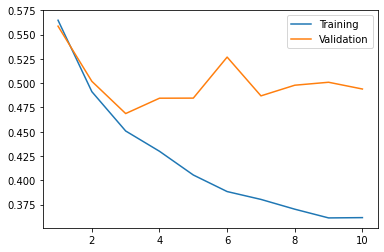

In [ ]:
plt.plot(df_stats["Training Loss"],label="Training")
plt.plot(df_stats["Valid. Loss"],label="Validation")
plt.legend()

In SGD we see a steady decrease in the training loss, while the validation loss rises drastically after 4 epochs, which is consistent with the model, as the source says, the Bert Sequence Classifier overfits after 4 epochs. As expected, SGD without momentum pretty much follows the basic nature and approaches the optimisation process in a naive way.

# SGD with momentum

In [18]:
from transformers import get_linear_schedule_with_warmup


epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer_sgd_mom, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()


    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        a = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss=a[0]
        logits=a[1]
        print(loss)


        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer_sgd_mom.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            b = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss=b[0]
            logits=b[1]
            
        # Accumulate the validation loss.
        total_eval_loss += loss

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [20]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.53,"tensor(0.4621, device='cuda:0')",0.78,0:02:45,0:00:06
2,0.40,"tensor(0.3743, device='cuda:0')",0.83,0:02:44,0:00:06
3,0.32,"tensor(0.4827, device='cuda:0')",0.82,0:02:42,0:00:06
4,0.27,"tensor(0.4143, device='cuda:0')",0.83,0:02:43,0:00:06
5,0.21,"tensor(0.5349, device='cuda:0')",0.82,0:02:43,0:00:06
6,0.17,"tensor(0.5666, device='cuda:0')",0.83,0:02:43,0:00:06
7,0.15,"tensor(0.6347, device='cuda:0')",0.82,0:02:43,0:00:06
8,0.12,"tensor(0.6909, device='cuda:0')",0.82,0:02:43,0:00:06
9,0.10,"tensor(0.7090, device='cuda:0')",0.82,0:02:43,0:00:06


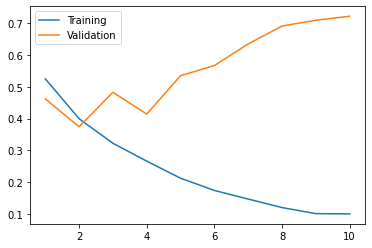

In [22]:
import matplotlib.pyplot as plt
plt.plot(df_stats["Training Loss"],label="Training")
plt.plot(df_stats["Valid. Loss"],label="Validation")
plt.legend()

Introducing momentum in SGD makes the model reach its minima much faster and after 3 epochs the validation loss starts rising which is an indication of overfit. This behaviour also is expected as here reaching the minimum becomes faster as the previous directions have an influence on the present ones.

## Adam

In [ ]:
epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer_adam, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()


    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        a = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss=a[0]
        logits=a[1]
        print(loss)


        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer_adam.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            b = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss=b[0]
            logits=b[1]
            
        # Accumulate the validation loss.
        total_eval_loss += loss

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.97,"tensor(0.6542, device='cuda:0')",0.71,0:02:39,0:00:06
2,0.95,"tensor(0.9195, device='cuda:0')",0.29,0:02:39,0:00:06
3,0.91,"tensor(1.4819, device='cuda:0')",0.29,0:02:39,0:00:06
4,0.90,"tensor(0.8943, device='cuda:0')",0.71,0:02:40,0:00:06
5,0.91,"tensor(1.3437, device='cuda:0')",0.71,0:02:40,0:00:06
6,0.84,"tensor(1.1742, device='cuda:0')",0.71,0:02:40,0:00:06
7,0.80,"tensor(0.6118, device='cuda:0')",0.71,0:02:39,0:00:06
8,0.69,"tensor(0.6030, device='cuda:0')",0.71,0:02:39,0:00:06
9,0.69,"tensor(0.6036, device='cuda:0')",0.71,0:02:39,0:00:06


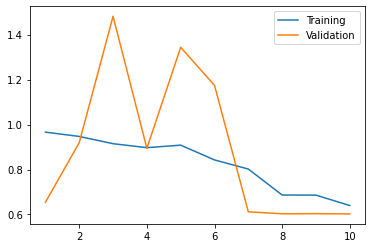

In [ ]:
plt.plot(df_stats["Training Loss"],label="Training")
plt.plot(df_stats["Valid. Loss"],label="Validation")
plt.legend()

Adam or Adaptive momentum shows a poor behaviour as the learning rate decreases very fast while we let the nature of the surface control the learning rate. We are at this disadvantage of decreasing learning rate and getting stuck somewhere in a saddle or local minima.

# RMSProp

In [ ]:
epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer_rmsprop, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()


    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        a = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss=a[0]
        logits=a[1]
        print(loss)


        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer_rmsprop.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            b = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss=b[0]
            logits=b[1]
            
        # Accumulate the validation loss.
        total_eval_loss += loss

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,4.92,"tensor(3.9475, device='cuda:0')",0.71,0:02:34,0:00:06
2,2.40,"tensor(0.8185, device='cuda:0')",0.29,0:02:34,0:00:06
3,2.05,"tensor(2.7775, device='cuda:0')",0.71,0:02:34,0:00:06
4,1.85,"tensor(0.8349, device='cuda:0')",0.29,0:02:34,0:00:06
5,1.63,"tensor(2.1218, device='cuda:0')",0.71,0:02:34,0:00:06
6,1.41,"tensor(0.6894, device='cuda:0')",0.71,0:02:34,0:00:06
7,1.21,"tensor(1.1064, device='cuda:0')",0.71,0:02:34,0:00:06
8,0.96,"tensor(0.6920, device='cuda:0')",0.71,0:02:34,0:00:06
9,0.78,"tensor(0.6050, device='cuda:0')",0.71,0:02:34,0:00:06


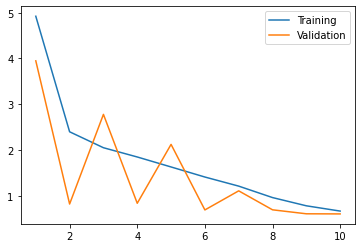

In [ ]:
plt.plot(df_stats["Training Loss"],label="Training")
plt.plot(df_stats["Valid. Loss"],label="Validation")
plt.legend()

This much better behaviour of RMSProp than Adam possibly is due to the fact that in the update rule, the gradient direction of present point gets to play an important role, which was not totally the case in Adam. So, here the fall in both training and validation loss shows a steady downward trend and the validation goes towards saturation after 10 epochs.

# QHM

In [21]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer_qhm, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()


    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        a = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss=a[0]
        logits=a[1]
        print(loss)


        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer_qhm.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            b = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss=b[0]
            logits=b[1]
            
        # Accumulate the validation loss.
        total_eval_loss += loss

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [24]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.62,"tensor(0.5933, device='cuda:0')",0.72,0:02:45,0:00:06
2,0.61,"tensor(0.5910, device='cuda:0')",0.72,0:02:45,0:00:06
3,0.61,"tensor(0.5886, device='cuda:0')",0.72,0:02:45,0:00:06
4,0.60,"tensor(0.5860, device='cuda:0')",0.72,0:02:45,0:00:06
5,0.60,"tensor(0.5834, device='cuda:0')",0.72,0:02:45,0:00:06
6,0.60,"tensor(0.5808, device='cuda:0')",0.72,0:02:45,0:00:06
7,0.59,"tensor(0.5788, device='cuda:0')",0.72,0:02:46,0:00:06
8,0.59,"tensor(0.5770, device='cuda:0')",0.72,0:02:46,0:00:06
9,0.59,"tensor(0.5758, device='cuda:0')",0.72,0:02:45,0:00:06


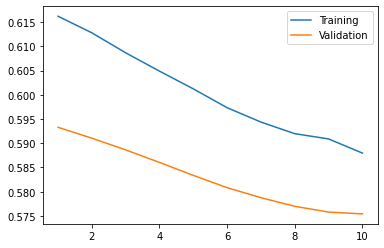

In [26]:
import matplotlib.pyplot as plt
plt.plot(df_stats["Training Loss"],label="Training")
plt.plot(df_stats["Valid. Loss"],label="Validation")
plt.legend()

As we mentioned above in the description, that QHM is the weighted average of momentum and SGD. The nature of fall that we see here is much smoother than both SGD and SGD with momentum. The only problem seems to be that the validation curve is below the training curve, which we can expect to change with more epochs. This behavior can also be due to random selection of starting point.

We shall carry on this study further with other models and frameworks. The interesting part of this notebook is, it shows the roles of the different algorithms that we have. It experiments with the parameters and tries to clarify the roles of each of them.